## Importation des librairies

In [ ]:
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [ ]:
df.shape

In [ ]:
df.describe()

## Prétraitement des données

In [ ]:
df = pd.read_excel('Default_Data.xlsx')
df.head()

,id,vintage_year,monthly_installment,loan_balance,bureau_score,num_bankrupt_iva,time_since_bankrupt,num_ccj,time_since_ccj,ccj_amount,...,months_since_2mia,avg_mia_6m,max_arrears_bal_6m,max_mia_6m,avg_bal_6m,avg_bureau_score_6m,cc_util,annual_income,emp_length,months_since_recent_cc_delinq
0,6670001,2005,746.70,131304.44,541.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,-42.0,0.0,132080.0,542.0,0.4578,76749,3,11
1,9131199,2006,887.40,115486.51,441.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,116972.0,494.0,0.6299,78451,10,7
2,4963167,2004,1008.50,128381.73,282.0,0.0,0.0,1.0,36.0,459.0,...,0.0,0.0,1198.0,2.0,128500.0,290.0,0.6331,31038,3,6
3,3918582,2005,458.23,35482.96,461.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,-114.0,0.0,36610.0,460.0,0.4990,56663,8,6
4,5949777,2006,431.20,77086.31,466.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,77518.0,468.0,0.9568,77014,10,3


### Gestion des valeurs manquantes

In [ ]:
# Environ 5% des données totales sont manquantes

round(df.isnull().sum().sum() / (df.shape[0]*df.shape[1]) * 100)

5

In [ ]:
# Colonnes avec des valeurs manquantes (en pourcentage)

colonnes_manquantes = df.isnull().sum()
round(colonnes_manquantes[colonnes_manquantes>0] / df.shape[0] * 100,2).apply(lambda x : str(x)+'%')

bureau_score                  1.67%
num_bankrupt_iva              1.67%
time_since_bankrupt           1.67%
num_ccj                       1.67%
time_since_ccj                1.67%
ccj_amount                    1.67%
num_bankrupt                  1.67%
num_iva                       1.67%
min_months_since_bankrupt     1.67%
region                         0.0%
recent_arrears_date          96.86%
months_since_2mia            96.86%
avg_mia_6m                    0.02%
max_arrears_bal_6m            0.02%
max_mia_6m                    0.02%
avg_bal_6m                    0.02%
avg_bureau_score_6m           1.51%
dtype: object

In [ ]:
# On supprime les colonnes avec un pourcentage trop grand de valeurs manquantes (96.86%)
df = df.drop(['recent_arrears_date', 'months_since_2mia'],axis=1)

In [ ]:
# On supprime les individus (lignes) avec plus de 5 valeurs manquantes
row = df.isnull().sum(axis=1)
df = df.drop(row[row>4].index,axis=0).reset_index(drop=True)

In [ ]:
# Remplacer les quelques dernieres valeurs manquantes
# de la variable "region" par sa classe classe majoritaire
df['region'] = df['region'].replace(np.nan,'r_d')

In [ ]:
# Remplacer les quelques dernieres valeurs manquantes
# de la variable "avg_bureau_score_6m" par la médiane de la variable

med = df['avg_bureau_score_6m'].median()
df['avg_bureau_score_6m'] = df['avg_bureau_score_6m'].replace(np.nan,med)

### Variables inutiles

In [ ]:
# 99.4 % de valeurs nulles dans la colonne "min_months_since_bankrupt", cette variable est donc quasi nulle.
L=round(df.min_months_since_bankrupt.value_counts() / df.shape[0]*100,1)
L[L>0]

0.0    99.4
Name: min_months_since_bankrupt, dtype: float64

In [ ]:
# Colonnes inutiles à supprimer :

# 'id': id du client
# 'maturity_date','origination_date' : date de maturité du pret et à l'origine.
# 'min_months_since_bankrupt' : variable avec 99.4% de 0, pratiquement nulle.

df = df.drop(['id','maturity_date','min_months_since_bankrupt','origination_date'],axis=1)

In [ ]:
# Autres variables inutiles n'ayant qu'une modalité dans le jeu de données
for col in df.columns:
  if len(df[col].value_counts())==1:
    print(col)
    df = df.drop([col],axis=1)

live_status
repaid_status
month


### Identification des variables catégorielles et continues

In [ ]:
# On utilise les distributions de chaque variable pour repérer les variables continues et celles catégorielles
for col in df.columns:
  print(df[col].value_counts())

2006    10259
2005     5742
2007     4494
2004     2441
2003     1544
2002      924
2012       26
2013       21
2014       15
2001        2
2015        1
Name: vintage_year, dtype: int64
0.01       20
509.20      9
451.50      9
545.90      8
325.10      8
           ..
619.01      1
106.73      1
1225.70     1
848.59      1
434.51      1
Name: monthly_installment, Length: 18136, dtype: int64
1.00         18
1.01          3
67619.78      2
76579.16      2
129623.78     2
             ..
74965.65      1
93841.59      1
98236.38      1
56378.55      1
55693.09      1
Name: loan_balance, Length: 25426, dtype: int64
504.0    125
515.0    125
496.0    115
523.0    114
505.0    112
        ... 
36.0       1
686.0      1
115.0      1
624.0      1
100.0      1
Name: bureau_score, Length: 634, dtype: int64
0.0    24294
1.0     1148
2.0       27
Name: num_bankrupt_iva, dtype: int64
0.0      24294
65.0        40
59.0        35
67.0        32
70.0        32
         ...  
81.0         1
115.0     

In [ ]:
# Après étude de chaque variable, on a pu répartir les variables selon les deux listes suivantes :
Var_categ = ['vintage_year','num_bankrupt_iva','num_ccj','num_bankrupt','num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m','max_mia_6m']

Var_continue = ['monthly_installment','loan_balance','bureau_score','time_since_bankrupt','time_since_ccj','ccj_amount','ltv','arrears_months','mob','remaining_mat','loan_term','max_arrears_12m','max_arrears_bal_6m','avg_bal_6m','avg_bureau_score_6m','cc_util','annual_income','emp_length','months_since_recent_cc_delinq']

### Transformation de certaines variables catégorielles

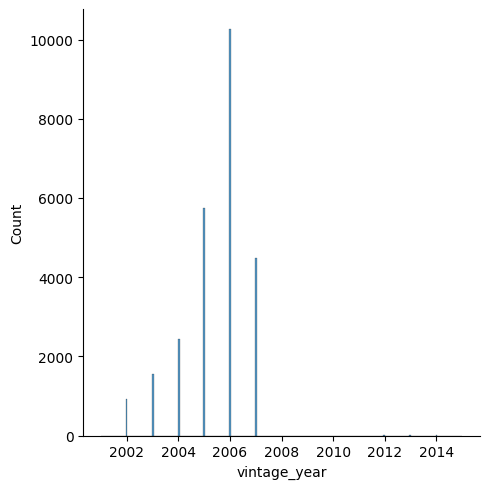

In [ ]:
# Selon sa distribution, la variable vintage_year est déséquilibrée
sn.displot(df['vintage_year'])

In [ ]:
# Ré-équilibrage de la variable vintage_year :

# Uniformisation : on transforme la variable en deux classes ("avant 2005", "après 2005")
df.loc[df['vintage_year'] <= 2005, 'vintage_year'] = 0
df.loc[df['vintage_year'] > 2005, 'vintage_year'] = 1

In [ ]:
# Selon sa distribution, la variable num_bankrupt_iva présente un taux trop faible de 2.
df['num_bankrupt_iva'].value_counts()

0.0    24294
1.0     1148
2.0       27
Name: num_bankrupt_iva, dtype: int64

In [ ]:
# Uniformisation : on convertit la variable num_bankrupt_iva en deux classes ("nulle", "non nulle")
df.loc[df['num_bankrupt_iva'] != 0, 'num_bankrupt_iva'] = 1

In [ ]:
# Selon sa distribution, la variable num_bankrupt_iva présente un taux trop faible de valeurs supérieures à 1.
df['num_ccj'].value_counts()

0.0     22838
1.0      1972
2.0       404
3.0       153
4.0        53
5.0        25
6.0        14
7.0         7
8.0         2
17.0        1
Name: num_ccj, dtype: int64

In [ ]:
# Uniformisation : on convertit la variable num_ccj en deux classes ("nulle", "non nulle")
df.loc[df['num_ccj'] != 0, 'num_ccj'] = 1

In [ ]:
# Selon sa distribution, la variable num_bankrupt_iva présente un taux trop faible de 7.
df['num_iva'].value_counts()

0.0    24533
1.0      929
2.0        7
Name: num_iva, dtype: int64

In [ ]:
# Uniformisation de "num_iva" : deux classes "nulle", "non nulle"
df.loc[df['num_iva'] != 0, 'num_iva'] = 1

In [ ]:
df.repayment_type.value_counts()

Non-IO    17223
IO         8246
Name: repayment_type, dtype: int64

In [ ]:
# On remplace les modalités de la variable repayment_type par 0 ou 1
# "Non-IO" par 0, "IO" par 1
df.repayment_type = df.repayment_type.replace({'Non-IO':0,"IO":1})

#### Dummification de la variable region

In [ ]:
df.region.value_counts()

r_d    4112
r_c    3880
r_i    3328
r_e    2852
r_g    2357
r_h    2205
r_l    1841
r_b    1703
r_a    1183
r_f    1141
r_m     867
Name: region, dtype: int64

In [ ]:
region = pd.get_dummies(df["region"])
df = df.merge(region, left_index = True, right_index = True).reset_index(drop = True)

In [ ]:
df = df.drop(['region'],axis=1)

### Correlations entre variables continues

<Axes: >

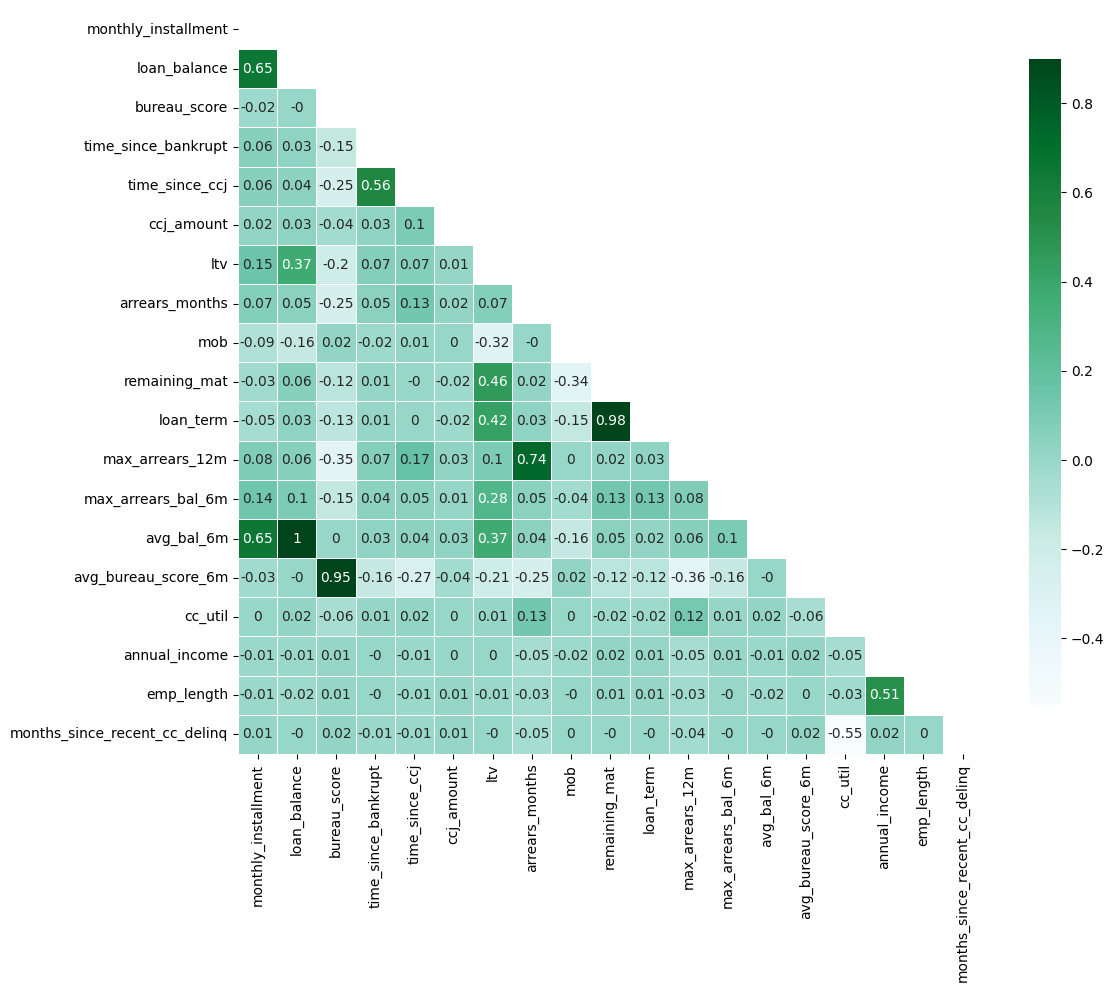

In [ ]:
# Matrice des corrélations de Pearson
corr = round(df[Var_continue].corr(method = 'pearson'),2)
fig, ax = plt.subplots(figsize = (12,12))
mask = np.triu(np.ones_like(corr, dtype=bool)) #mask upper triangle
sn.heatmap(corr, mask=mask, vmax = 0.9, cmap='BuGn', square = True, annot = True, linewidths=.5, cbar_kws={"shrink": .7})

In [ ]:
df2 = df.drop(['loan_balance','avg_bureau_score_6m','loan_term'],axis=1)

In [ ]:
df2

,vintage_year,monthly_installment,bureau_score,num_bankrupt_iva,time_since_bankrupt,num_ccj,time_since_ccj,ccj_amount,num_bankrupt,num_iva,...,r_b,r_c,r_d,r_e,r_f,r_g,r_h,r_i,r_l,r_m
0,0,746.70,541.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,887.40,441.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,0,1008.50,282.0,0.0,0.0,1.0,36.0,459.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,0,458.23,461.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,1,431.20,466.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25464,0,1457.50,293.0,0.0,0.0,1.0,48.0,11578.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
25465,0,1021.32,227.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
25466,1,62.12,441.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
25467,1,782.80,319.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


### Examples d'effets visuels sur la variable cible

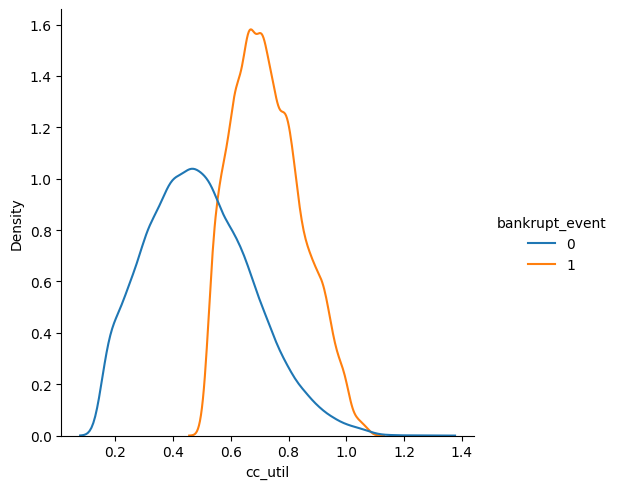

In [ ]:
sn.displot(df2, x = "cc_util", hue = 'bankrupt_event', kind = 'kde', fill = False)

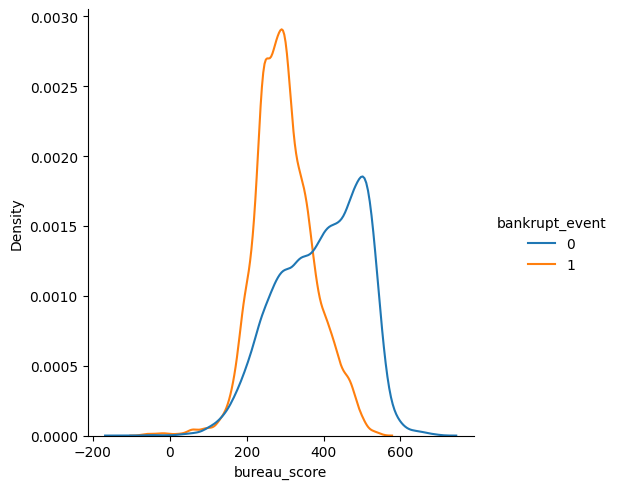

In [ ]:
sn.displot(df2, x = "bureau_score", hue = 'bankrupt_event', kind = 'kde', fill = False)

### Réechantillonnage de la variable cible

Comme on peut le voir ci-dessous, la variable cible est extremement déséquilibrée (99% de clients sans défauts). On procède donc à une méthode de réechantillonnage nommée SMOTE (cf. article, partie 6.2 Imbalanced data sets) afin de rémedier à ce problème.

In [ ]:
df2.bankrupt_event.value_counts()

0    25238
1      231
Name: bankrupt_event, dtype: int64

In [ ]:
# Séparation des caractéristiques et les étiquettes
X = df2.drop('bankrupt_event', axis=1)
y = df2['bankrupt_event']

# Application de SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Création du nouveau DataFrame avec les données équilibrées
balanced = pd.concat([X_resampled, y_resampled], axis=1)

## Modèles Prédictifs

### Création des échantillons d'entrainement et de test

In [ ]:
X = balanced.drop(['bankrupt_event'],axis=1)
y = balanced.bankrupt_event.astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,random_state=42)

### Random Forest

#### Recherche des hyperparamètres

In [ ]:
rfc=RandomForestClassifier(random_state=19)

param_grid = {
    'n_estimators': [50,100,200,300,350,400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,20,30,30,40,50,60,70],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

{'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}


#### Résultats du modèle

Score de précision sur l'entrainement : 0.9733
Score de précision sur le test : 0.9667
sensibilité du modèle : 0.9536
spécificité du modèle : 0.98


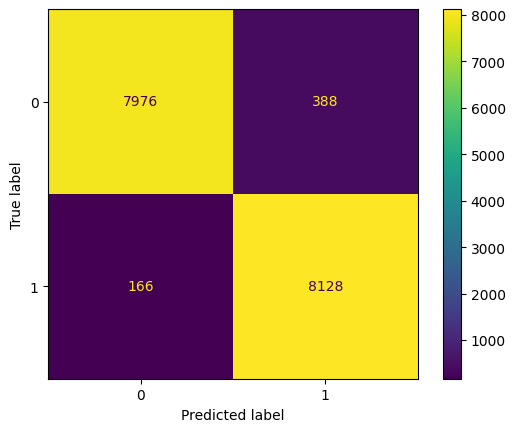

In [ ]:
# Modèle
RFC = RandomForestClassifier(n_estimators=50, max_depth=10,random_state=19)
RFC.fit(X_train, y_train)
y_pred_RFC = RFC.predict(X_test)
print("Score de précision sur l'entrainement : "+str(round(RFC.score(X_train,y_train), 4)))
print("Score de précision sur le test : "+str(round(RFC.score(X_test,y_test), 4)))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_RFC,labels=RFC.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=RFC.classes_)

# Sensibilité
print("sensibilité du modèle : "+ str(round(cm[0,0] / (cm[0,1] + cm[0,0]),4)))

# Spécificité
print("spécificité du modèle : "+ str(round(cm[1,1] / (cm[1,1] + cm[1,0]),4)))

disp.plot()

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test,y_pred_RFC)

0.9670434265318262

### SVM

#### Normalisation des données

In [ ]:
# Normalisation des données pour faciliter la prédiction faite par le SVM
x = X
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [ ]:
# Re-séparation du jeu de données normalisé
X_train_, X_test_, y_train_, y_test_ = train_test_split(df, y, test_size = 0.33, random_state = 0)

#### Recherche des hyperparamètres

In [ ]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train_, y_train_)

grid.best_params_

{'C': 100, 'gamma': 0.1, 'kernel': 'linear'}


#### Résultats du modèle

Score de précision sur l'entrainement : 0.9648
Score de précision sur le test : 0.9619
sensibilité du modèle : 0.9708
spécificité du modèle : 0.953


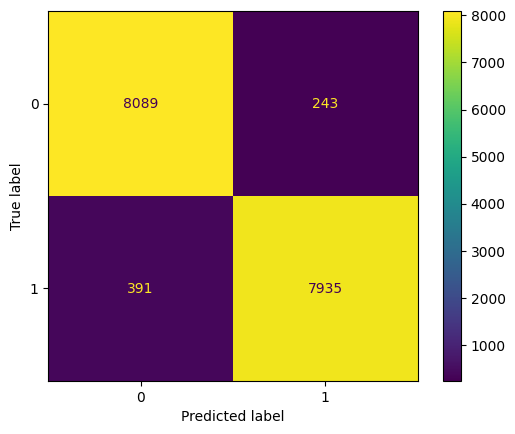

In [ ]:
# SVM with optimal parameters
SVM = svm.SVC(**{'C': 100, 'gamma': 0.1, 'kernel': 'linear','probability':True})
SVM.fit(X_train_, y_train_)
y_pred_SVM = SVM.predict(X_test_)
print("Score de précision sur l'entrainement : "+str(round(SVM.score(X_train_,y_train_), 4)))
print("Score de précision sur le test : "+str(round(SVM.score(X_test_,y_test_), 4)))

# Matrice de confusion
cm = confusion_matrix(y_test_, y_pred_SVM,labels=SVM.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)

# Sensibilité
print("sensibilité du modèle : "+ str(round(cm[0,0] / (cm[0,1] + cm[0,0]),4)))

# Spécificité
print("spécificité du modèle : "+ str(round(cm[1,1] / (cm[1,1] + cm[1,0]),4)))

disp.plot()


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test_,y_pred_SVM)

0.9615850702859913

In [ ]:
pred_prob_SVM = SVM.predict_proba(X_test_)

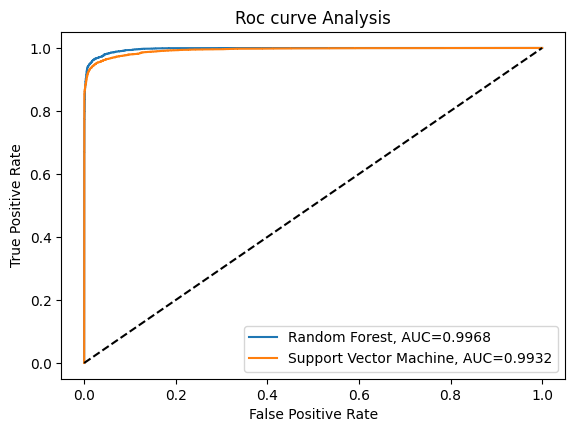

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(6.5,4.5))
fpr, tpr, _ = metrics.roc_curve(y_test, RFC.predict_proba(X_test)[:, 1])
auc = round(metrics.roc_auc_score(y_test, RFC.predict_proba(X_test)[:, 1]), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test_, pred_prob_SVM[:, 1])
auc = round(metrics.roc_auc_score(y_test_, pred_prob_SVM[:, 1]), 4)
plt.plot(fpr,tpr,label="Support Vector Machine, AUC="+str(auc))

plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.title('Roc curve Analysis')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

On sélectionne alors le Random Forest qui présente les meilleurs resultats.

### Importances des variables dans la prédiction

In [ ]:
imp/100

,0
vintage_year,0.001939
monthly_installment,0.008360
bureau_score,0.120096
num_bankrupt_iva,0.023657
time_since_bankrupt,0.015648
num_ccj,0.028542
time_since_ccj,0.021487
ccj_amount,0.004620
num_bankrupt,0.001509
num_iva,0.028264


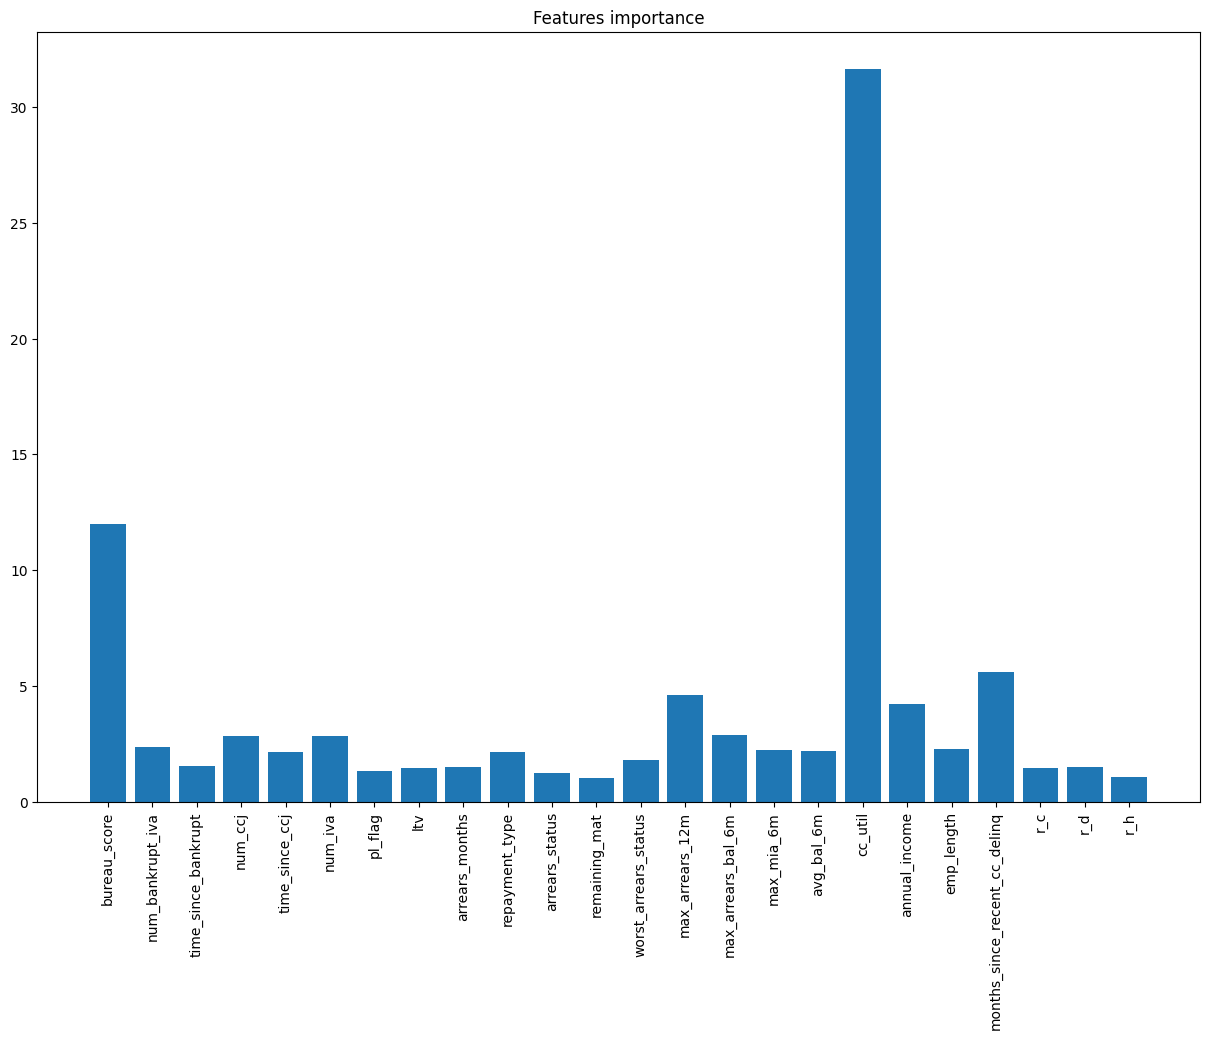

In [ ]:
imp = pd.DataFrame(RFC.feature_importances_)
imp.index=X.columns

imp = imp*100
imp[imp[0]>1]

plt.figure(figsize=(15,10))

plt.title('Features importance')
plt.bar(imp[imp[0]>1].index, imp[imp[0]>1][0])
plt.xticks(rotation=90)
plt.show()